In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from util import *

In [4]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [5]:
model_name = 'ViT-B-16'
pretrained_dset = 'laion400m_e31'



In [50]:
models_to_consider = [
    ('ViT-L-14','laion2b_s32b_b82k'),
   ('ViT-B-16','laion400m_e31')
]

In [49]:
xaxis = np.arange(0.5, 3, 0.05)
dataset_robustness = {}
for model_name, pretrained_dset in models_to_consider:
    model, _, preprocess = open_clip.create_model_and_transforms(model_name,
        pretrained=pretrained_dset,
        device=device)
    tokenizer = open_clip.get_tokenizer(model_name)
    ece_ds = {}
    for dataset_name in ['CIFAR100', 'CIFAR10','SUN397']:
        dset,_ = get_test_set(dataset_name, preprocess)
        image_features, actual = get_image_features(
            model,  dset,  batch_size=batch_size, device=device
        )
        _ , templates = get_openai_prompts(dataset_name)
        
        
        prompt_eces = []
        for text_template in tqdm(templates):
            temp_eces = []
            for temp in (xaxis):
                predictions, probs = get_preds_from_img_features(model, tokenizer, dset, image_features, text_template=text_template, temp_scaling=temp,
                        device = device)
                ECE, _, acc = get_metrics(predictions, actual, probs)
                temp_eces.append(ECE)
            prompt_eces.append(temp_eces)
        ece_ds[dataset_name] = prompt_eces
    dataset_robustness[model_name + ';' + pretrained_dset] = ece_ds

Files already downloaded and verified


100%|██████████| 18/18 [00:55<00:00,  3.11s/it]


Files already downloaded and verified


100%|██████████| 2/2 [00:22<00:00, 11.42s/it]


Files already downloaded and verified


100%|██████████| 18/18 [00:35<00:00,  1.97s/it]


Files already downloaded and verified


100%|██████████| 2/2 [00:15<00:00,  7.93s/it]


In [51]:
dataset_robustness.keys()

dict_keys(['ViT-L-14;laion2b_s32b_b82k', 'ViT-B-16;laion400m_e31'])

In [52]:
imagenet_supervised_temps = {'ViT-B-16;laion2b_s34b_b88k': 1.3878337144851685,
 'ViT-L-14;laion2b_s32b_b82k': 1.4129570722579956,
 'ViT-B-32;laion2b_s34b_b79k': 1.4092495441436768,
 'ViT-B-16;openai': 0.9825258851051331,
 'ViT-L-14;openai': 1.0273551940917969,
 'ViT-B-32;openai': 0.9789162874221802,
 'ViT-B-16;laion400m_e31': 1.6131701469421387,
 'ViT-L-14;laion400m_e31': 1.7537566423416138,
 'ViT-B-32;laion400m_e31': 1.37242591381073,
 'RN50;openai': 0.9742085933685303,
 'RN50;yfcc15m': 2.5651497840881348,
 'RN50;cc12m': 2.662893295288086,
 'ViT-H-14;laion2b_s32b_b79k': 1.5119352340698242}

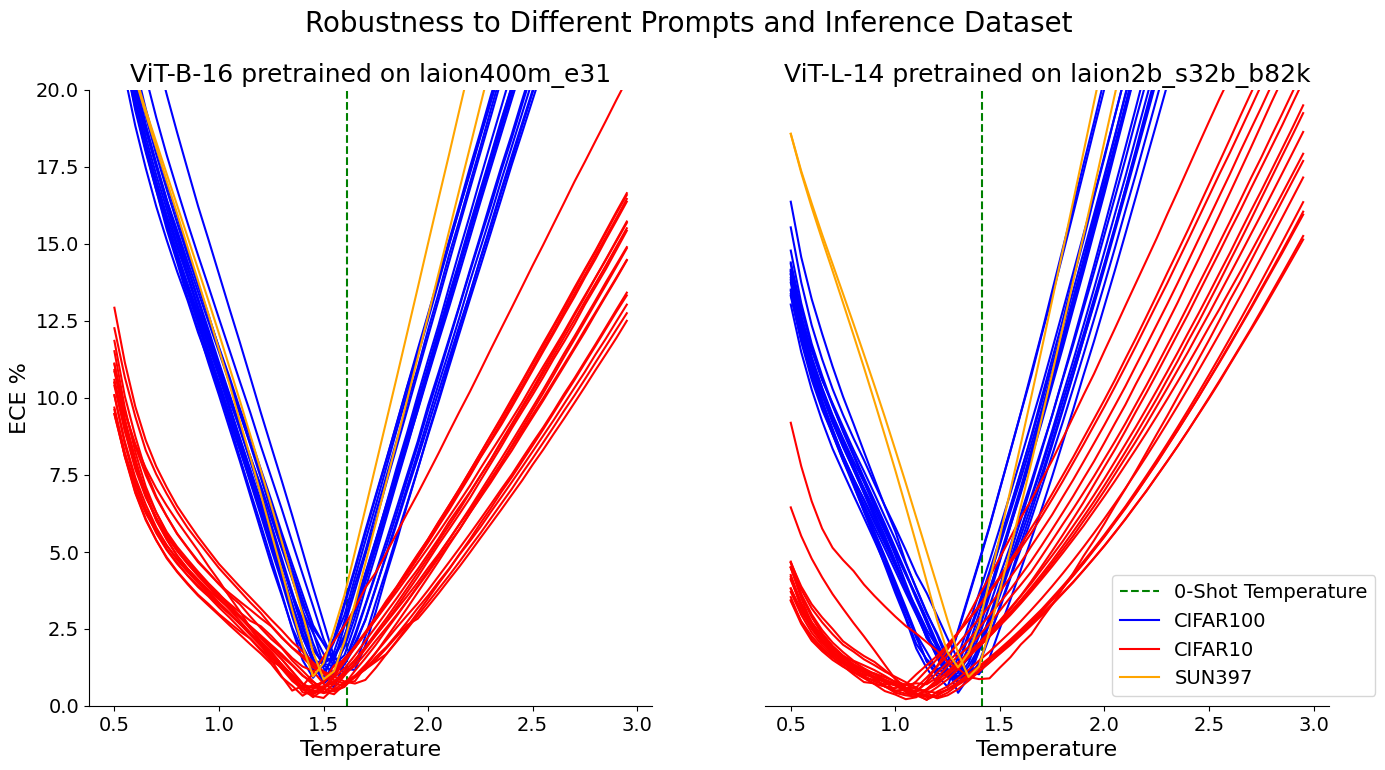

In [99]:
fig, axarr = plt.subplots(1,2, figsize=(16,8))
import matplotlib

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

colors = {
    'CIFAR100' : 'b',
    'CIFAR10' : 'r',
    'SUN397' : 'orange',
    #'Food101' : 'purple'
}

for ax in axarr:
    ax.set_xlabel('Temperature', fontsize=16)
    ax.set_ylabel('ECE %', fontsize=16)
    ax.set_ylim(0, 20)
    ax.spines[['right', 'top']].set_visible(False)
    
axarr[1].spines[['left']].set_visible(False)
axarr[1].axes.get_yaxis().set_visible(False)

straight_line = np.arange(0, 100)
axarr[0].plot([imagenet_supervised_temps['ViT-B-16;laion400m_e31']] * len(straight_line), straight_line, '--',color='green', label='Temperature Found on Imagenet')
axarr[1].plot([imagenet_supervised_temps['ViT-L-14;laion2b_s32b_b82k']] * len(straight_line), straight_line, '--', color='green', label='0-Shot Temperature')

axarr[0].set_title(f"ViT-B-16 pretrained on laion400m_e31",fontsize=18)
axarr[1].set_title(f"ViT-L-14 pretrained on laion2b_s32b_b82k",fontsize=18)


for k in ece_ds:
    for i in range(len(ece_ds[k])):
        axarr[0].plot(xaxis, np.array(dataset_robustness['ViT-B-16;laion400m_e31'][k][i]) * 100.0, color=colors[k], label=k)
        
for k in ece_ds:
    for i in range(len(ece_ds[k])):
        axarr[1].plot(xaxis, np.array(dataset_robustness['ViT-L-14;laion2b_s32b_b82k'][k][i]) * 100.0, color=colors[k], label=k)
        

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axarr[1].legend(by_label.values(), by_label.keys(), fontsize=14, loc='lower right', bbox_to_anchor=(1.1,0))
plt.suptitle('Robustness to Different Prompts and Inference Dataset', fontsize=20)
plt.savefig('plots/robustness.png')

In [36]:
dataset_robustness['ViT-L-14;laion2b_s32b_b82k'][k]

[[0.1417964896714834,
  0.1314243569010234,
  0.12080633121567583,
  0.1099274895960518,
  0.09905846010145875,
  0.08783462345328139,
  0.07649996740765384,
  0.06498208561283043,
  0.05335183672877758,
  0.04148506248607341,
  0.029626344671326382,
  0.017382030693101985,
  0.008560378429740709,
  0.011185888502953585,
  0.020850885479726966,
  0.033162442109069414,
  0.046197690727731416,
  0.0592961621908509,
  0.07262147379182884,
  0.08589419289762903,
  0.0993748603493474,
  0.11294949231979282,
  0.126543964922776,
  0.1403253702656055,
  0.1539950823070061],
 [0.13799792879098935,
  0.1270492081637597,
  0.11565849826359922,
  0.10438930481112857,
  0.09238386518300798,
  0.08073656852638414,
  0.06862873532572905,
  0.05616573774245044,
  0.043837614373253384,
  0.031100945188897798,
  0.019356729414095844,
  0.009515955401419342,
  0.013809016259274592,
  0.024687571714365888,
  0.03592636462977711,
  0.04985858592277721,
  0.06390680341554086,
  0.07817619194342508,
  0.092

In [37]:
dataset_robustness['ViT-B-16;laion400m_e31'][k]

[[0.1417964896714834,
  0.1314243569010234,
  0.12080633121567583,
  0.1099274895960518,
  0.09905846010145875,
  0.08783462345328139,
  0.07649996740765384,
  0.06498208561283043,
  0.05335183672877758,
  0.04148506248607341,
  0.029626344671326382,
  0.017382030693101985,
  0.008560378429740709,
  0.011185888502953585,
  0.020850885479726966,
  0.033162442109069414,
  0.046197690727731416,
  0.0592961621908509,
  0.07262147379182884,
  0.08589419289762903,
  0.0993748603493474,
  0.11294949231979282,
  0.126543964922776,
  0.1403253702656055,
  0.1539950823070061],
 [0.13799792879098935,
  0.1270492081637597,
  0.11565849826359922,
  0.10438930481112857,
  0.09238386518300798,
  0.08073656852638414,
  0.06862873532572905,
  0.05616573774245044,
  0.043837614373253384,
  0.031100945188897798,
  0.019356729414095844,
  0.009515955401419342,
  0.013809016259274592,
  0.024687571714365888,
  0.03592636462977711,
  0.04985858592277721,
  0.06390680341554086,
  0.07817619194342508,
  0.092